In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
import time
from numba import njit,prange

In [91]:
@njit(boundscheck=True)
def FDM_BIv03(Vrf, Vdc):
    
    #Define the parameters that make up your trap
    #For the mirror ** For now, just assume there is no hole at the bottom or holes for the slits, and mirror takes up all of lower surface **
    Hmirror = .00323; #mirror height
    Ropening = .00508; # radius at Hmirror
    #for the top endcap
    Htopcap = 0.0035; #distance from bottom of mirror to bottom of top end cap
    Ttopcap = .001; #thickness of top end cap
    PlateWidth = 0.013; #width of bias plate arms
    PlateLength = 0.01; # From center of mirror point to bias plate edge
    TGroundPlate = 0.001; #Thickness of grounded plate on top of Bias plates
    #for the needle
    Hneedle = -0.0006; #height of needle inside trap up until the beginning of the needle tip
    Rneedle = 0.00023; #radius of needle
    HneedleTip = 0.0024; # height of needle tip from needle body
    RneedleTip = 0.00002;
    theta = 2*np.arctan(Rneedle/HneedleTip); #opening angle of needle tip cone

    #Not sure what to do with this yet: mirror_equation = (Hmirror / Ropening**2) * (x**2 +y**2); #the equation describing the shape of the mirror (paraboloid). form of z=(1/a^2)(x^2+y^2)
    
    #Properties of our grid
    gmax = 0.0075#physical size of the space simulated (meters)
    points = 401 # number of points that are being simulated
    steps = points - 1 # just the number of points minus one
    x = np.linspace(-gmax, gmax, points) #chosing how much space in the x, y, z direction, where it begins and where it ends
    y = np.linspace(-gmax, gmax, points)
    z = np.linspace(0, 2*gmax, points)
    size = len(x) # telling it how to organize these spaces
    sizeZ = len(z)
    xmid = int((size)/2)
    ymid = int((size)/2)
    zmid = int((sizeZ)/2) 
    lattice_points=np.zeros((size**3,3))
    marker=0 #What do these mean?

    
    V0 = np.zeros((size, size, size)) #initialize the matrix for electric potential
    V0dc= np.zeros((size, size, size))
    V0_temp=np.zeros((size, size, size))
    V0dc_temp=np.zeros((size, size, size))
    cords=np.zeros((size, size, size, 3))
    iterations = 400 #number of iterations
    CenterV = np.zeros((iterations,1)) #keep track of the potential value at the center at each iteration
    
    
    #Now define the boundry conditions

    for i in range(len(x)):
        for j in range(len(y)):
            for k in range(len(z)):
                cords[i, j, k] = [i, j, k]
                
                #The top end cap Htopcap <= z <= Htopcap +Ttopcap
                 #Arm one of Bias plates
                if ((x[i] >= -PlateWidth/2) and (x[i] <= PlateWidth/2) and (y[j] > Ropening -0.000) and (z[k] > Htopcap) and (z[k] < (Htopcap + Ttopcap))):
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                #Arm Two of bias plate
                elif ((y[j] >= -PlateWidth/2) and (y[j] <= PlateWidth/2) and (x[i] > Ropening-0.000) and (z[k] > Htopcap) and (z[k] < (Htopcap + Ttopcap))):
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                #Arm three of bias plate
                elif ((x[i] >= -PlateWidth/2) and (x[i] <= PlateWidth/2) and (y[j] < -Ropening +0.00) and (z[k] > Htopcap) and (z[k] < (Htopcap + Ttopcap))):
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                #Arm four of bias plate
                elif ((y[j] >= -PlateWidth/2) and (y[j] <= PlateWidth/2) and (x[i] < -Ropening+0.000) and (z[k] > Htopcap) and (z[k] < (Htopcap + Ttopcap))):
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                    
                #Grounded top plate
                 #Arm one of Grounded plates
                elif ((x[i] >= -PlateWidth/2) and (x[i] <= PlateWidth/2) and (y[j] > Ropening) and (z[k] > Htopcap + Ttopcap+ 0.0002) and (z[k] < (Htopcap + Ttopcap + TGroundPlate +0.0002))):
                    V0[i, j, k] = Vrf[3] #what do these numbers mean?
                    V0dc[i, j, k] = Vdc[3]
                #Arm Two of Grounded plate
                elif ((y[j] >= -PlateWidth/2) and (y[j] <= PlateWidth/2) and (x[i] > Ropening) and (z[k] > Htopcap + Ttopcap+ 0.0002) and (z[k] < (Htopcap + Ttopcap + TGroundPlate +0.0002))):
                    V0[i, j, k] = Vrf[3] #what do these numbers mean?
                    V0dc[i, j, k] = Vdc[3]
                #Arm three of grounded plate
                elif ((x[i] >= -PlateWidth/2) and (x[i] <= PlateWidth/2) and (y[j] < -Ropening) and (z[k] > Htopcap + Ttopcap+ 0.0002) and (z[k] < (Htopcap + Ttopcap + TGroundPlate +0.0002))):
                    V0[i, j, k] = Vrf[3] #what do these numbers mean?
                    V0dc[i, j, k] = Vdc[3]
                #Arm four of grounded plate
                elif ((y[j] >= -PlateWidth/2) and (y[j] <= PlateWidth/2) and (x[i] < -Ropening) and (z[k] > Htopcap + Ttopcap+ 0.0002) and (z[k] < (Htopcap + Ttopcap + TGroundPlate +0.0002))):
                    V0[i, j, k] = Vrf[3] #what do these numbers mean?
                    V0dc[i, j, k] = Vdc[3]
                
                #The mirror
                elif ((z[k] > 0) and (z[k] < Hmirror) and (z[k] <= (Hmirror / Ropening**2) * (x[i]**2 + y[j]**2))):
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                
                #The needle
                elif ((y[j] < np.sqrt(Rneedle - x[i]**2)) and (x[i] < Rneedle) and (x[i] > -Rneedle) and (y[j] > -np.sqrt(Rneedle - x[i]**2)) and (y[j] < Rneedle) and (y[j] > -Rneedle) and (z[k] > 0) and (z[k] < Hneedle)):
                #elif ((z[k] < ((x[i] + y[j]) + np.sqrt(3 * Rneedle**2 + 6 * x[i] * y[i])) / 2) and (z[k] > -((x[i] + y[j]) + np.sqrt(3 * Rneedle**2 + 6 * x[i] * y[i])) / 2) and (z[k] > 0) and (z[k] <Hneedle) and (np.abs(x[i]) < Rneedle) and (np.abs(y[j] < Rneedle))):
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                #The needle tip
                elif ((z[k] < - np.sqrt(x[i]**2 + y[j]**2)*12.5 +0.002) and (x[i] < Rneedle) and (x[i] > -Rneedle) and (y[j] > -Rneedle) and (y[j] < Rneedle) and (z[k] > Hneedle) and (z[k] < Hneedle + HneedleTip)):
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                #the very tip of the needle (to hopefully avoid fringing effects)
                elif ((z[k] > Hneedle + HneedleTip -0.0001) and (z[k]< Hneedle + HneedleTip + 0.0001) and (z[k] < np.sqrt(RneedleTip**2 - x[i]**2 - y[j]**2) + 0.002)):
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                    
               # and (x[i] < Rneedle) and (x[i] > -Rneedle)     
                #In the space with no electrodes:
                else:
                    V0[i, j, k] = 0
                    V0dc[i, j, k] = 0
                    lattice_points[marker]=[i,j,k]
                    marker+=1
                    
    lattice_points=lattice_points[0:marker] # what does this mean?
                
    V0_temp=V0    
    V0dc_temp=V0dc
    
    
    for iterate in range(0,int(iterations/2)): 
         for I in range (marker):
             point=lattice_points[I]
             a=int(point[0])
             b=int(point[1])
             c=int(point[2])
             if ((a>3 and b>3 and c>3 and a<points-5 and b<points-5 and c<points-5)):
                 V0_temp[a,b,c] = 1/6*(V0[a+4,b,c]+V0[a-4,b,c]+V0[a,b+4,c]+V0[a,b-4,c]+V0[a,b,c+4]+V0[a,b,c-4])
                 V0dc_temp[a,b,c] = 1/6*(V0dc[a+4,b,c]+V0dc[a-4,b,c]+V0dc[a,b+4,c]+V0dc[a,b-4,c]+V0dc[a,b,c+4]+V0dc[a,b,c-4])
             
       
        
         CenterV[iterate] = V0[xmid,ymid,zmid]
         V0=V0_temp
         V0dc=V0dc_temp
          # iterate+=1
         # print(iterate)

    
    ## Define the initial potential using FDM in small steps
   # disp(['Calculating V in small steps...'])


    for iterate in range(int(iterations/2),int(3*iterations/4)):
         for I in range (marker):
             point=lattice_points[I]
             a=int(point[0])
             b=int(point[1])
             c=int(point[2])
             if ((a>1 and b>1 and c>1 and a<points-3 and b<points-3 and c<points-3)):
                 V0_temp[a,b,c] = 1/6*(V0[a+2,b,c]+V0[a-2,b,c]+V0[a,b+2,c]+V0[a,b-2,c]+V0[a,b,c+2]+V0[a,b,c-2])
                 V0dc_temp[a,b,c] = 1/6*(V0dc[a+2,b,c]+V0dc[a-2,b,c]+V0dc[a,b+2,c]+V0dc[a,b-2,c]+V0dc[a,b,c+2]+V0dc[a,b,c-2])
             
                    
                   
                   
       
         CenterV[iterate] = V0[xmid,ymid,zmid]
         V0=V0_temp
         V0dc=V0dc_temp
        
    return V0,V0dc,CenterV,lattice_points,cords

In [92]:
    ###Sample voltages to use in the simulation
RF=np.array([0, 600, 0, 0])
DC=np.array([600,0, 0, 0])
####record the start time
start=time.time()
#Run the simulation
A=FDM_BIv03(RF,DC)
print("time elapsed = ",time.time()-start, "seconds")

time elapsed =  180.77594447135925 seconds


[0, 100, 0, 350]

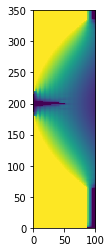

In [93]:
plt.imshow(A[0][:,200,:])#, cmap=plt.cm.get_cmap('viridis', 2))

plt.axis([0,100 , 0, 350])

In [94]:
####***grid size in metres, size is number of lattice points. V is a NxNxN grid of potential values Feturns NxNxN grid of Efield magnitudes
def Efield_solve(V,size,grid):
    
    Ex=np.zeros((size,size,size))
    Ey=np.zeros((size,size,size))
    Ez=np.zeros((size,size,size))
    Ex,Ey,Ez = np.gradient(V,grid/size)
    Emag=np.zeros((size,size,size))
    for a in range(0,size):
       for b in range(0,size):
          
          for c in range(0,size):
              Emag[a,b,c] = math.sqrt(Ex[a,b,c]**2+Ey[a,b,c]**2+Ez[a,b,c]**2)
    return Emag
###return pseudopotential in eV. E_field must be NxNxN
def Pseudo_solve(E_field,size,grid,omega,M,Q):
    PseudoeV=np.zeros((size,size,size))
    for a in range(0,size):
       for b in range(0,size):
          for c in range(0,size):
              PseudoeV[a,b,c] = Q**2/(4*M*omega**2)*E_field[a,b,c]**2
    return PseudoeV
###tahes dc potential and pseudo potential to give effective potential energy
def Eeff(PS,Vdc,Q,size):
    PE=np.zeros((size,size,size),dtype=np.long)
    for a in range(0,size):
       for b in range(0,size):
          for c in range(0,size):
              PE[a,b,c]=Q*Vdc[a,b,c]+PS[a,b,c]
    return PE
def Force_field(PE,grid,steps):
    return np.gradient(PE,grid/steps)     

In [95]:
start=time.time()
B=Efield_solve(A[0], 351, 0.014)
print("time elapsed = ",time.time()-start, "seconds")

time elapsed =  105.1558735370636 seconds


In [96]:
####record the start time
start=time.time()
C = Pseudo_solve(B, 351, 0.014, 13085000*2*np.pi, 2.8*10**-25, 1)* 1.6*10**-19
print("time elapsed = ",time.time()-start)


time elapsed =  64.81376504898071


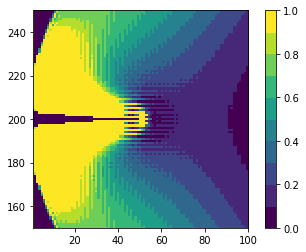

In [101]:
R= plt.imshow(C[:,200,:], cmap=plt.cm.get_cmap('viridis', 10)) #viridis
plt.colorbar()
plt.clim(0,1)
plt.axis([1,100 , 150, 250])
plt.show()


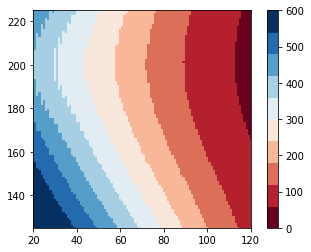

In [65]:
R= plt.imshow(A[0][:,175,:], cmap=plt.cm.get_cmap('RdBu', 10))
plt.colorbar()
#plt.clim(0,.1e-11)
plt.axis([20,120 , 125, 225])
plt.show()

[50, 80, 0, 0.2]

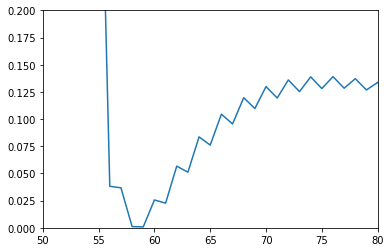

In [99]:
plt.plot(C[200, 200, :])
plt.axis([50, 80, 0, .2]) #300 points 6000 iterations gave 2.35 eV :(
#350 points, 600 iterations gives 3.30 eV, 1000 iterations gives 3.08 eV, 2000 iterations give 2.59 eV, 3000 gives 2.41 eV, 4000 gives 2.34